<a href="https://colab.research.google.com/github/liae15/ColabComp345/blob/main/NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes Text Classification

## Classifying Sentences from *Emma* and *Moby Dick*

In this notebook, we'll implement a **Naive Bayes classifier** to predict whether a sentence comes from Jane Austen's *Emma* or Herman Melville's *Moby Dick* based on word frequencies.

### We will...
- Cover the Naive Bayes classification algorithm
- See how to calculate prior and likelihood probabilities
- Apply log probabilities to avoid numerical underflow
- Implement additive/Laplace smoothing to handle zero probabilities
- Evaluate classifier performance (this part will be covered in the lecture on 20.01.2026!)

---
## Part 0: Pandas Primer

Before we dive into Naive Bayes, let's review **Pandas**, the Python library that most people use to work with large datasets.

### What is Pandas?
Pandas is a powerful data analysis library that provides two main data structures:
- **Series**: A 1-dimensional labeled array (like a column)
- **DataFrame**: A 2-dimensional labeled table (like a spreadsheet)

### Key Pandas Operations

Let's see some basic Pandas functionality with a toy example:

In [ ]:
import pandas as pd
import numpy as np

# Create a simple DataFrame
toy_data = {
    'sentence': ['The whale was large.', 'Emma was delighted.', 'The sea was calm.'],
    'source': ['Moby Dick', 'Emma', 'Moby Dick'],
    'the': [1, 0, 1],
    'was': [1, 1, 1],
    'whale': [1, 0, 0]
}

df = pd.DataFrame(toy_data)
print("Our toy DataFrame:")
print(df)
print("\n" + "="*60)

Our toy DataFrame:
               sentence     source  the  was  whale
0  The whale was large.  Moby Dick    1    1      1
1   Emma was delighted.       Emma    0    1      0
2     The sea was calm.  Moby Dick    1    1      0



**Note that our toy example reflects the same data structure of the data we'll eventually work with:**

    * Each row represents a sentence.
    * The 'sentence' column tells us what that sentence is.
    * The 'source' column tells us if it was taken from Moby Dick or Emma.
    * The remaining columns (e.g., 'the', 'was', 'whale') indicate the feature count for each sentence. Here, our features are a set of words that may or may not appear in each sentence.

In [ ]:
# Accessing columns
print("\n1. ACCESSING COLUMNS")
print("-" * 40)
print(df['source'])


1. ACCESSING COLUMNS
----------------------------------------
0    Moby Dick
1         Emma
2    Moby Dick
Name: source, dtype: object


In [ ]:
# Filtering rows
print("\n2. FILTERING ROWS")
print("-" * 40)
print("Only sentences from Moby Dick:")
moby_sentences = df[df['source'] == 'Moby Dick']
print(moby_sentences)


2. FILTERING ROWS
----------------------------------------
Only sentences from Moby Dick:
               sentence     source  the  was  whale
0  The whale was large.  Moby Dick    1    1      1
2     The sea was calm.  Moby Dick    1    1      0


In [ ]:
# Counting values
print("\n3. COUNTING VALUES (here, by 'source')")
print("-" * 40)
print(df['source'].value_counts())

# Total number of rows
print(f"\nTotal rows: {len(df)}")


3. COUNTING VALUES (here, by 'source')
----------------------------------------
source
Moby Dick    2
Emma         1
Name: count, dtype: int64

Total rows: 3


In [ ]:
# Summing columns
print("\n4. AGGREGATING DATA")
print("-" * 40)
print("Total occurrences of 'the' across all sentences:")
print(df['was'].sum())

print("\nTotal occurrences of 'the' in Moby Dick sentences:")
print(df[df['source'] == 'Moby Dick']['whale'].sum())


4. AGGREGATING DATA
----------------------------------------
Total occurrences of 'the' across all sentences:
3

Total occurrences of 'the' in Moby Dick sentences:
1


In [ ]:
# Getting column names
print("\n5. INSPECTING THE DATAFRAME")
print("-" * 40)
print("All column names:")
print(df.columns.tolist())

print("\nDataFrame shape (rows, columns):")
print(df.shape)

print("\nFirst 2 rows:")
print(df.head(2))


5. INSPECTING THE DATAFRAME
----------------------------------------
All column names:
['sentence', 'source', 'the', 'was', 'whale']

DataFrame shape (rows, columns):
(3, 5)

First 2 rows:
               sentence     source  the  was  whale
0  The whale was large.  Moby Dick    1    1      1
1   Emma was delighted.       Emma    0    1      0


These operations will be essential for our Naive Bayes implementation! But we can now move on to the actual classification task.

---
## Part 1: Loading the Data

Our data has already been preprocessed. Each CSV file contains:
- **sentence**: The original text
- **source**: The book it came from ("Emma" or "Moby Dick")
- **Word columns**: Count of each feature word in that sentence

The feature set consists of 132 words: the union of the top 100 most frequent words from each book.

**Note that in this example, we have not applied any of the keyword search methods from previous lectures.** So we have a lot of common words like 'the' in our feature set. Leaving them in keeps things simpler, and also lets us see how some words (like 'and', etc.) don't contribute much to classifying a sentence, while others (like 'whale') will.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math

# Set plotting style
sns.set_theme(style="whitegrid", palette="muted")
sns.set_context("notebook", font_scale=1.1)

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [ ]:
# Load the preprocessed data
train_df = pd.read_csv('https://raw.githubusercontent.com/grvkamath/temp-for-nl2ds/refs/heads/main/naive_bayes_data/train_set.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/grvkamath/temp-for-nl2ds/refs/heads/main/naive_bayes_data/test_set.csv')

print("=" * 70)
print("DATA LOADED")
print("=" * 70)
print(f"Training set: {len(train_df):,} sentences")
print(f"Test set: {len(test_df):,} sentences")
print(f"\nTotal features (word columns): {len(train_df.columns) - 2}")

DATA LOADED
Training set: 16,845 sentences
Test set: 500 sentences

Total features (word columns): 132


In [ ]:
# Examine the first few rows
print("\nFirst 3 rows of training data:")
print(train_df.head(3))


First 3 rows of training data:
                                            sentence source  like  by  their  \
0  [Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAP...   Emma     0   1      0   
1  She was the youngest of the two daughters of a...   Emma     0   0      0   
2  Her mother\nhad died too long ago for her to h...   Emma     0   1      0   

   with  this  over  seemed  knightley  ...  me  other  no  who  ahab  now  \
0     2     0     0       1          0  ...   0      0   0    0     0    0   
1     0     0     0       0          0  ...   0      0   0    0     0    0   
2     0     0     0       0          0  ...   0      0   0    1     0    0   

   be  boat  miss  more  
0   0     0     0     0  
1   0     0     0     0  
2   0     0     0     1  

[3 rows x 134 columns]


In [ ]:
# Get the feature words (all columns except 'sentence' and 'source')
feature_words = [col for col in train_df.columns if col not in ['sentence', 'source']]

print(f"\nWe have {len(feature_words)} feature words.")
print(f"\nA random sample of 20 feature words: {np.random.choice(feature_words, 20)}")


We have 132 feature words.

A random sample of 20 feature words: ['her' 'if' 'you' 'for' 'great' 'a' 'before' 'me' 'these' 'down' 'quite'
 'of' 'be' 'whale' 'who' 'were' 'ahab' 'about' 'other' 'me']


In [ ]:
# Distribution of sentences by source
print("\n" + "=" * 70)
print("TRAINING SET DISTRIBUTION")
print("=" * 70)

train_counts = train_df['source'].value_counts()
for source, count in train_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"{source}: {count:,} sentences ({percentage:.1f}%)")

print("\n" + "=" * 70)
print("TEST SET DISTRIBUTION")
print("=" * 70)

test_counts = test_df['source'].value_counts()
for source, count in test_counts.items():
    percentage = (count / len(test_df)) * 100
    print(f"{source}: {count:,} sentences ({percentage:.1f}%)")


TRAINING SET DISTRIBUTION
Moby Dick: 9,553 sentences (56.7%)
Emma: 7,292 sentences (43.3%)

TEST SET DISTRIBUTION
Moby Dick: 299 sentences (59.8%)
Emma: 201 sentences (40.2%)


---
## Part 2: Understanding Naive Bayes

### The Naive Bayes Formula

For a sentence with words $w_1, w_2, ..., w_n$, we want to find which class $c$ (Emma or Moby Dick) is most likely:

$$P(c | w_1, w_2, ..., w_n) \propto P(c) \cdot P(w_1 | c) \cdot P(w_2 | c) \cdot ... \cdot P(w_n | c)$$

Where:
- **$P(c)$** is the **prior probability** of class $c$
- **$P(w_i | c)$** is the **likelihood** of word $w_i$ given class $c$
- The "naive" assumption: words are independent given the class

### Why "Naive"?
We assume words appear independently (e.g., seeing "whale" doesn't affect probability of seeing "sea"). This is clearly false in reality (think: word order!), but it simplifies the math and works surprisingly well.

---
## Part 3: Calculating Prior Probabilities

The **prior probability** $P(c)$ is simply the proportion of training sentences from class $c$.

In [ ]:
# Calculate priors
total_train = len(train_df)
emma_count = len(train_df[train_df['source'] == 'Emma'])
moby_count = len(train_df[train_df['source'] == 'Moby Dick'])

prior_emma = emma_count / total_train
prior_moby = moby_count / total_train

print("=" * 70)
print("PRIOR PROBABILITIES")
print("=" * 70)
print(f"P(Emma) = {emma_count}/{total_train} = {prior_emma:.4f}")
print(f"P(Moby Dick) = {moby_count}/{total_train} = {prior_moby:.4f}")
print(f"\nSum of priors: {prior_emma + prior_moby:.4f} (should be 1.0)")

PRIOR PROBABILITIES
P(Emma) = 7292/16845 = 0.4329
P(Moby Dick) = 9553/16845 = 0.5671

Sum of priors: 1.0000 (should be 1.0)


### Interpretation
If we had to guess the source of a sentence **without looking at any words**, we'd guess Moby Dick about 57% of the time and Emma about 43% of the time, based on the training data proportions.

---
## Part 4: Calculating Word Frequencies and Likelihoods

For each word $w$ in our vocabulary, we need:

$$P(w | \text{Emma}) = \frac{\text{count of } w \text{ in Emma sentences}}{\text{total words in Emma sentences}}$$

And similarly for Moby Dick.

In [ ]:
# Separate training data by source
train_emma = train_df[train_df['source'] == 'Emma']
train_moby = train_df[train_df['source'] == 'Moby Dick']

# For each feature word, sum up its occurrences across all sentences in each book
emma_word_counts = {}
moby_word_counts = {}

for word in feature_words:
    emma_word_counts[word] = train_emma[word].sum()
    moby_word_counts[word] = train_moby[word].sum()

# Calculate total word counts (sum of all feature words)
emma_total_words = sum(emma_word_counts.values())
moby_total_words = sum(moby_word_counts.values())

print("=" * 70)
print("WORD COUNTS IN TRAINING DATA")
print("=" * 70)
print(f"Total feature word occurrences in Emma: {emma_total_words:,}")
print(f"Total feature word occurrences in Moby Dick: {moby_total_words:,}")

WORD COUNTS IN TRAINING DATA
Total feature word occurrences in Emma: 96,150
Total feature word occurrences in Moby Dick: 110,831


In [ ]:
# Look at some specific word counts
example_words = ['whale', 'she', 'and', 'is', 'sea', 'emma', 'ahab']

print("\n" + "=" * 80)
print("EXAMPLE WORD COUNTS")
print("=" * 80)
print(f"{'Word':<12}{'Emma Count':<15}{'Moby Count':<15}{'Total':<10}")
print("-" * 80)

for word in example_words:
    if word in feature_words:
        e_count = emma_word_counts[word]
        m_count = moby_word_counts[word]
        total = e_count + m_count
        print(f"{word:<12}{e_count:<15}{m_count:<15}{total:<10}")
    else:
        print(f"{word:<12}{'NOT IN VOCAB':<15}{'NOT IN VOCAB':<15}{'N/A':<10}")


EXAMPLE WORD COUNTS
Word        Emma Count     Moby Count     Total     
--------------------------------------------------------------------------------
whale       0              1057           1057      
she         2281           119            2400      
and         4748           6219           10967     
is          1220           1694           2914      
sea         10             373            383       
emma        834            0              834       
ahab        0              500            500       


### Observation
Notice how certain words are strongly associated with one book:
- **"whale"**, **"sea"**, **"ahab"** appear much more in Moby Dick
- **"she"**, **"emma"** appear much more in Emma
- words like **"and"** and **"is"** are common in both

In [ ]:
# Calculate word probabilities (likelihoods) WITHOUT smoothing
emma_word_probs = {}
moby_word_probs = {}

for word in feature_words:
    emma_word_probs[word] = emma_word_counts[word] / emma_total_words
    moby_word_probs[word] = moby_word_counts[word] / moby_total_words

# Display probabilities for example words
print("\n" + "=" * 90)
print("WORD LIKELIHOODS (WITHOUT SMOOTHING)")
print("=" * 90)
print(f"{'Word':<12}{'P(w|Emma)':<18}{'P(w|Moby)':<18}{'Ratio (E/M)':<15}")
print("-" * 90)

for word in example_words:
    if word in feature_words:
        e_prob = emma_word_probs[word]
        m_prob = moby_word_probs[word]
        ratio = e_prob / m_prob if m_prob > 0 else float('inf')
        print(f"{word:<12}{e_prob:<18.6f}{m_prob:<18.6f}{ratio:<15.2f}")
    else:
        print(f"{word:<12}{'NOT IN VOCAB':<18}{'NOT IN VOCAB':<18}{'N/A':<15}")


WORD LIKELIHOODS (WITHOUT SMOOTHING)
Word        P(w|Emma)         P(w|Moby)         Ratio (E/M)    
------------------------------------------------------------------------------------------
whale       0.000000          0.009537          0.00           
she         0.023723          0.001074          22.09          
and         0.049381          0.056112          0.88           
is          0.012689          0.015285          0.83           
sea         0.000104          0.003365          0.03           
emma        0.008674          0.000000          inf            
ahab        0.000000          0.004511          0.00           


### Understanding the Ratio
- If **Ratio (E/M) > 1**: Word is more common in Emma
- If **Ratio (E/M) < 1**: Word is more common in Moby Dick
- A very high or very low ratio indicates a strong discriminative word

Notice how the ratio is fairly close to 1 for **"and"** and **"is"**, but for the other words, it is completely skewed!

---
## Part 5: The Zero Probability Problem

What happens if a word appears in one book but **never** appears in the other?

For example, if "whale" never appears in Emma's training data, then:
- $P(\text{"whale"} | \text{Emma}) = 0$
- Any sentence containing "whale" would get $P(\text{sentence} | \text{Emma}) = 0$
- The entire probability collapses to zero...

Let's check for such words:

In [ ]:
# Find words with zero count in either book
emma_zero_words = [word for word in feature_words if emma_word_counts[word] == 0]
moby_zero_words = [word for word in feature_words if moby_word_counts[word] == 0]

print("=" * 70)
print("ZERO PROBABILITY WORDS")
print("=" * 70)
print(f"Words that NEVER appear in Emma training: {len(emma_zero_words)}")
if emma_zero_words:
    print(f"  Examples: {emma_zero_words}")

print(f"\nWords that NEVER appear in Moby Dick training: {len(moby_zero_words)}")
if moby_zero_words:
    print(f"  Examples: {moby_zero_words}")

ZERO PROBABILITY WORDS
Words that NEVER appear in Emma training: 4
  Examples: ['ship', 'whale', 'ahab', 'boat']

Words that NEVER appear in Moby Dick training: 7
  Examples: ['knightley', 'jane', 'elton', 'weston', 'woodhouse', 'emma', 'harriet']


### The Solution: Additive / Laplace Smoothing

**Additive / Laplace smoothing** (add-one smoothing) prevents zero probabilities by adding a small count to every word:

$$P_{\text{smooth}}(w | c) = \frac{\text{count}(w, c) + \alpha}{\text{total words in } c + \alpha \cdot V}$$

Where:
- $\alpha$ is the smoothing parameter (often 1, but we can set this to any small value)
- $V$ is the vocabulary size (number of unique words)

This ensures no probability is ever zero, while minimally affecting common words.

In [ ]:
# Calculate word probabilities WITH Laplace smoothing (alpha = 1)
alpha = 1
vocab_size = len(feature_words)

emma_word_probs_smooth = {}
moby_word_probs_smooth = {}

for word in feature_words:
    emma_word_probs_smooth[word] = (emma_word_counts[word] + alpha) / (emma_total_words + alpha * vocab_size)
    moby_word_probs_smooth[word] = (moby_word_counts[word] + alpha) / (moby_total_words + alpha * vocab_size)

# Compare before and after smoothing for zero-count words
print("=" * 90)
print("EFFECT OF SMOOTHING ON ZERO-COUNT WORDS")
print("=" * 90)
print(f"{'Word':<12}{'Emma (before)':<18}{'Emma (after)':<18}{'Moby (before)':<18}{'Moby (after)':<18}")
print("-" * 90)

# Show words with zero counts
check_words = (emma_zero_words[:3] if emma_zero_words else []) + (moby_zero_words[:3] if moby_zero_words else [])
if not check_words:
    # If no zero words, show some example words anyway
    check_words = ['whale', 'she', 'the']

for word in check_words:
    if word in feature_words:
        e_before = emma_word_probs[word]
        e_after = emma_word_probs_smooth[word]
        m_before = moby_word_probs[word]
        m_after = moby_word_probs_smooth[word]
        print(f"{word:<12}{e_before:<18.8f}{e_after:<18.8f}{m_before:<18.8f}{m_after:<18.8f}")

EFFECT OF SMOOTHING ON ZERO-COUNT WORDS
Word        Emma (before)     Emma (after)      Moby (before)     Moby (after)      
------------------------------------------------------------------------------------------
ship        0.00000000        0.00001039        0.00413242        0.00413651        
whale       0.00000000        0.00001039        0.00953704        0.00953471        
ahab        0.00000000        0.00001039        0.00451137        0.00451502        
knightley   0.00385855        0.00386365        0.00000000        0.00000901        
jane        0.00303692        0.00304314        0.00000000        0.00000901        
elton       0.00392096        0.00392597        0.00000000        0.00000901        


**Key Insight**: Smoothing gives zero-count words a small non-zero probability, preventing the entire product from collapsing to zero!

---
## Part 6: Log Probabilities

### The Underflow Problem
When we multiply many small probabilities together, we quickly get numbers too small for computers to represent:

$$0.001 \times 0.002 \times 0.003 \times ... \text{ (many terms)} \rightarrow 0$$

### The Solution: Log Space
Instead of multiplying probabilities, we **add log-probabilities**:

$$\log(P(c) \cdot P(w_1|c) \cdot P(w_2|c) \cdot ...) = \log P(c) + \log P(w_1|c) + \log P(w_2|c) + ...$$

This is mathematically equivalent but numerically stable.

In [ ]:
# Calculate log probabilities for words
emma_word_logprobs = {word: np.log(prob) for word, prob in emma_word_probs_smooth.items()}
moby_word_logprobs = {word: np.log(prob) for word, prob in moby_word_probs_smooth.items()}

# Calculate log priors
log_prior_emma = np.log(prior_emma)
log_prior_moby = np.log(prior_moby)

print("=" * 70)
print("LOG PROBABILITIES")
print("=" * 70)
print(f"log P(Emma) = {log_prior_emma:.4f}")
print(f"log P(Moby Dick) = {log_prior_moby:.4f}")

print("\n" + "=" * 90)
print("EXAMPLE LOG WORD LIKELIHOODS")
print("=" * 90)
print(f"{'Word':<12}{'log P(w|Emma)':<20}{'log P(w|Moby)':<20}")
print("-" * 90)

for word in ['whale', 'she', 'the', 'sea', 'and']:
    if word in feature_words:
        e_log = emma_word_logprobs[word]
        m_log = moby_word_logprobs[word]
        print(f"{word:<12}{e_log:<20.4f}{m_log:<20.4f}")

LOG PROBABILITIES
log P(Emma) = -0.8373
log P(Moby Dick) = -0.5672

EXAMPLE LOG WORD LIKELIHOODS
Word        log P(w|Emma)       log P(w|Moby)       
------------------------------------------------------------------------------------------
whale       -11.4750            -4.6528             
she         -3.7422             -6.8295             
the         -2.9404             -2.0728             
sea         -9.0771             -5.6927             
and         -3.0093             -2.8814             


### Interpreting Log Probabilities
- **More negative** = less probable
- **Less negative** = more probable
- If **log P(w|Emma) > log P(w|Moby)**, word is more likely in Emma

**IMPORTANT:** When comparing log probabilities like these, when we say $logP(A) < logP(B)$, we mean this including the negative sign, and NOT in terms of the absolute magnitude. For example, if $logP(A)=-15.68$, and $logP(B)=-7.02$, we would say that $logP(A) < logP(B)$.

---
## Part 7: Making Predictions

Now we can classify a sentence! For each class, we calculate:

$$\text{score}(c) = \log P(c) + \sum_{w \in \text{sentence}} \text{count}(w) \cdot \log P(w|c)$$

We predict the class with the **highest score**.

In [ ]:
def classify_sentence(sentence_row, feature_words, log_prior_emma, log_prior_moby,
                     emma_word_logprobs, moby_word_logprobs):
    """
    Classify a single sentence using Naive Bayes.

    Parameters:
    - sentence_row: A row from the DataFrame containing word counts
    - feature_words: List of feature word columns
    - log_prior_emma, log_prior_moby: Log prior probabilities
    - emma_word_logprobs, moby_word_logprobs: Dictionaries of log word probabilities

    Returns:
    - prediction: 'Emma' or 'Moby Dick'
    - emma_score: Log probability score for Emma
    - moby_score: Log probability score for Moby Dick
    """
    # Start with the prior (log probability of the class)
    emma_score = log_prior_emma
    moby_score = log_prior_moby

    # Add contribution from each word
    for word in feature_words:
        count = sentence_row[word]
        if count > 0:
            # Add log probability of this word, weighted by its count
            emma_score += count * emma_word_logprobs[word]
            moby_score += count * moby_word_logprobs[word]

    # Predict the class with higher score
    prediction = 'Emma' if emma_score > moby_score else 'Moby Dick'

    return prediction, emma_score, moby_score


### Test on a Single Example

In [ ]:
# Let's classify a random test sentence
test_idx = np.random.randint(0, len(test_df))
test_sentence = test_df.iloc[test_idx]

pred, emma_score, moby_score = classify_sentence(
    test_sentence, feature_words, log_prior_emma, log_prior_moby,
    emma_word_logprobs, moby_word_logprobs
)

print("=" * 80)
print("EXAMPLE CLASSIFICATION")
print("=" * 80)
print(f"\nSentence: {test_sentence['sentence'][:200]}...")
print(f"\nTrue source: {test_sentence['source']}")
print(f"Predicted source: {pred}")
print(f"\nEmma score (log prob): {emma_score:.2f}")
print(f"Moby Dick score (log prob): {moby_score:.2f}")
print(f"\nDifference: {emma_score - moby_score:.2f}")
print(f"Prediction: {pred} ({'✓ CORRECT' if pred == test_sentence['source'] else '✗ INCORRECT'})")

EXAMPLE CLASSIFICATION

Sentence: I had blown out the candle; and the
mere thought of Queequeg--not four feet off--sitting there in that
uneasy position, stark alone in the cold and dark; this made me
really wretched....

True source: Moby Dick
Predicted source: Moby Dick

Emma score (log prob): -63.50
Moby Dick score (log prob): -59.03

Difference: -4.47
Prediction: Moby Dick (✓ CORRECT)


### BONUS: Let's see which words contributed most to this prediction

In [ ]:
# Analyze word contributions for this sentence
word_contributions = []
for word in feature_words:
    count = test_sentence[word]
    if count > 0:
        emma_contrib = count * emma_word_logprobs[word]
        moby_contrib = count * moby_word_logprobs[word]
        diff = emma_contrib - moby_contrib
        word_contributions.append({
            'word': word,
            'count': count,
            'emma_contrib': emma_contrib,
            'moby_contrib': moby_contrib,
            'difference': diff
        })

# Sort by absolute difference
word_contributions.sort(key=lambda x: abs(x['difference']), reverse=True)

print("\n" + "=" * 100)
print("TOP DISCRIMINATIVE WORDS IN THIS SENTENCE")
print("=" * 100)
print(f"{'Word':<12}{'Count':<8}{'Emma Contrib':<16}{'Moby Contrib':<16}{'Difference':<16}{'Favors':<10}")
print("-" * 100)

for item in word_contributions[:10]:
    favors = 'Emma' if item['difference'] > 0 else 'Moby Dick'
    print(f"{item['word']:<12}{item['count']:<8}{item['emma_contrib']:<16.3f}{item['moby_contrib']:<16.3f}"
          f"{item['difference']:<16.3f}{favors:<10}")


TOP DISCRIMINATIVE WORDS IN THIS SENTENCE
Word        Count   Emma Contrib    Moby Contrib    Difference      Favors    
----------------------------------------------------------------------------------------------------
the         3       -8.821          -6.218          -2.603          Moby Dick 
in          2       -7.636          -6.632          -1.004          Moby Dick 
had         1       -4.112          -4.992          0.879           Emma      
this        1       -5.225          -4.404          -0.821          Moby Dick 
not         1       -3.767          -4.550          0.783           Emma      
out         1       -6.162          -5.381          -0.781          Moby Dick 
i           1       -3.436          -3.986          0.550           Emma      
that        1       -4.003          -3.611          -0.392          Moby Dick 
there       1       -5.193          -4.880          -0.313          Moby Dick 
of          1       -3.135          -2.858          -0.277        

---
## Part 8: Evaluating on the Test Set

Let's classify all test sentences and calculate accuracy.

In [ ]:
# Classify all test sentences
predictions = []
true_labels = []
emma_scores = []
moby_scores = []

for idx, row in test_df.iterrows():
    pred, e_score, m_score = classify_sentence(
        row, feature_words, log_prior_emma, log_prior_moby,
        emma_word_logprobs, moby_word_logprobs
    )
    predictions.append(pred)
    true_labels.append(row['source'])
    emma_scores.append(e_score)
    moby_scores.append(m_score)

# Add predictions to test dataframe
test_df['prediction'] = predictions
test_df['emma_score'] = emma_scores
test_df['moby_score'] = moby_scores
test_df['correct'] = test_df['source'] == test_df['prediction']

In [ ]:
# Calculate accuracy
accuracy = (test_df['correct'].sum() / len(test_df)) * 100

print("\n" + "=" * 70)
print("CLASSIFICATION RESULTS")
print("=" * 70)
print(f"Total test sentences: {len(test_df)}")
print(f"Correct predictions: {test_df['correct'].sum()}")
print(f"Incorrect predictions: {(~test_df['correct']).sum()}")
print(f"\nAccuracy: {accuracy:.2f}%")


CLASSIFICATION RESULTS
Total test sentences: 500
Correct predictions: 431
Incorrect predictions: 69

Accuracy: 86.20%


In [ ]:
# Detailed breakdown by class
print("\n" + "=" * 70)
print("ACCURACY BY CLASS")
print("=" * 70)

for source in ['Emma', 'Moby Dick']:
    source_df = test_df[test_df['source'] == source]
    source_correct = source_df['correct'].sum()
    source_total = len(source_df)
    source_accuracy = (source_correct / source_total) * 100
    print(f"\n{source}:")
    print(f"  Correct: {source_correct}/{source_total}")
    print(f"  Accuracy: {source_accuracy:.2f}%")


ACCURACY BY CLASS

Emma:
  Correct: 166/201
  Accuracy: 82.59%

Moby Dick:
  Correct: 265/299
  Accuracy: 88.63%


### Confusion Matrix
A confusion matrix shows where our classifier makes mistakes:

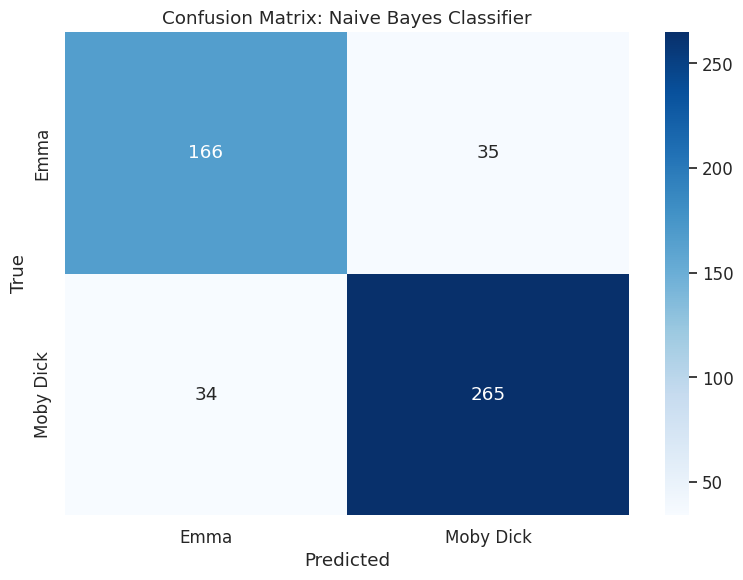


Reading the confusion matrix:
  True Emma, Predicted Emma: 166
  True Emma, Predicted Moby Dick: 35
  True Moby Dick, Predicted Emma: 34
  True Moby Dick, Predicted Moby Dick: 265


In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df['source'], test_df['prediction'], labels=['Emma', 'Moby Dick'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Emma', 'Moby Dick'],
            yticklabels=['Emma', 'Moby Dick'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Naive Bayes Classifier')
plt.tight_layout()
plt.show()

print("\nReading the confusion matrix:")
print(f"  True Emma, Predicted Emma: {cm[0, 0]}")
print(f"  True Emma, Predicted Moby Dick: {cm[0, 1]}")
print(f"  True Moby Dick, Predicted Emma: {cm[1, 0]}")
print(f"  True Moby Dick, Predicted Moby Dick: {cm[1, 1]}")

---
## BONUS: Part 9: Examining Errors

Let's look at some sentences the classifier got wrong to understand its limitations.

In [ ]:
# Get incorrect predictions
errors = test_df[~test_df['correct']].copy()

print("=" * 80)
print(f"EXAMINING {len(errors)} ERRORS")
print("=" * 80)

if len(errors) > 0:
    # Sort by confidence (score difference)
    errors['score_diff'] = abs(errors['emma_score'] - errors['moby_score'])
    errors_sorted = errors.sort_values('score_diff', ascending=True)

    print("\nMost Uncertain Errors (small score difference):")
    print("-" * 80)

    for i, (idx, row) in enumerate(errors_sorted.head(3).iterrows()):
        print(f"\n{i+1}. True: {row['source']}, Predicted: {row['prediction']}")
        print(f"   Score difference: {row['score_diff']:.2f}")
        sentence_preview = row['sentence'][:150] + "..." if len(row['sentence']) > 150 else row['sentence']
        print(f"   Sentence: {sentence_preview}")
else:
    print("\nNo errors! Perfect classification!")

EXAMINING 69 ERRORS

Most Uncertain Errors (small score difference):
--------------------------------------------------------------------------------

1. True: Moby Dick, Predicted: Emma
   Score difference: 0.02
   Sentence: What India to England?

2. True: Moby Dick, Predicted: Emma
   Score difference: 0.10
   Sentence: I misdoubt me that I disobey my God in obeying
him!"

3. True: Moby Dick, Predicted: Emma
   Score difference: 0.12
   Sentence: No!


---
## BONUS: Part 10: Interactive Exploration

Let's visualize how discriminative different words are.

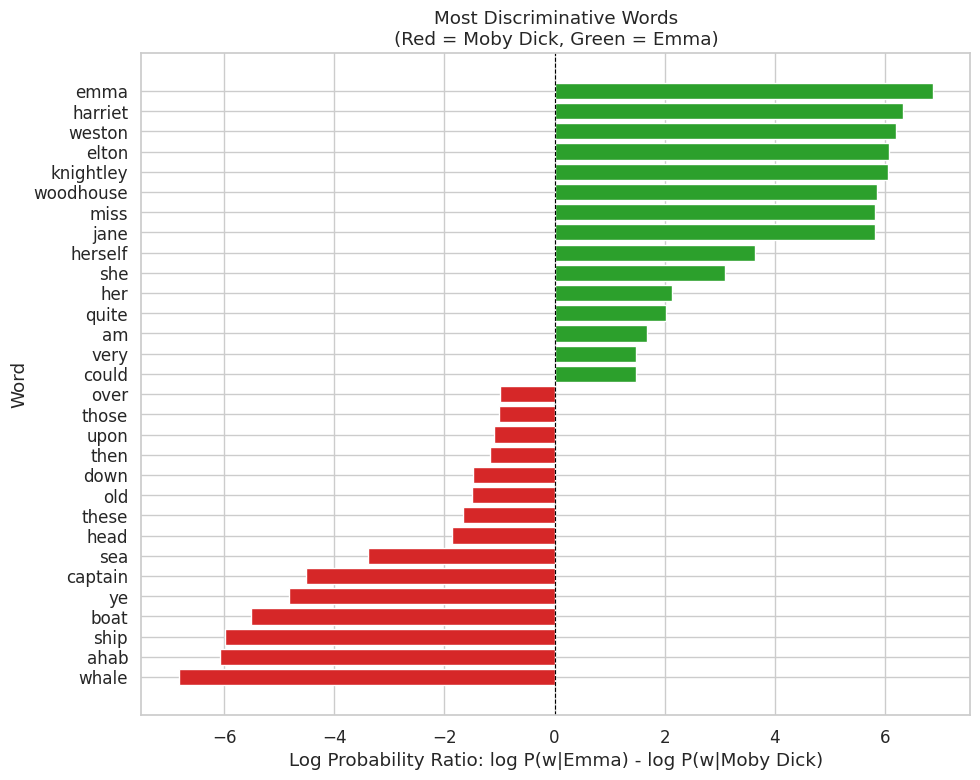

In [ ]:
# Calculate log probability ratio for each word
word_ratios = []
for word in feature_words:
    log_ratio = emma_word_logprobs[word] - moby_word_logprobs[word]
    total_count = emma_word_counts[word] + moby_word_counts[word]
    word_ratios.append({
        'word': word,
        'log_ratio': log_ratio,
        'total_count': total_count
    })

# Convert to DataFrame
word_ratios_df = pd.DataFrame(word_ratios)
word_ratios_df = word_ratios_df.sort_values('log_ratio')

# Get top Emma words and top Moby words
top_emma = word_ratios_df.tail(15)
top_moby = word_ratios_df.head(15)

# Combine for plotting
top_words = pd.concat([top_moby, top_emma])

# Plot
plt.figure(figsize=(10, 8))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in top_words['log_ratio']]
plt.barh(top_words['word'], top_words['log_ratio'], color=colors)
plt.xlabel('Log Probability Ratio: log P(w|Emma) - log P(w|Moby Dick)')
plt.ylabel('Word')
plt.title('Most Discriminative Words\n(Red = Moby Dick, Green = Emma)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

### Interpretation
- Words on the **right** (green) are strongly associated with Emma
- Words on the **left** (red) are strongly associated with Moby Dick
- The further from zero, the more discriminative the word

---
## Summary

1. **Naive Bayes Classification**: Uses Bayes' theorem with the "naive" independence assumption

2. **Prior Probabilities**: $P(c)$ represents the base rate of each class

3. **Likelihoods**: $P(w|c)$ represents how likely each word is given the class

4. **Additive/Laplace Smoothing**: Prevents zero probabilities by adding a small count to all words

5. **Log Probabilities**: Prevents numerical underflow when multiplying many small probabilities

6. **Classification**: Choose the class with the highest posterior probability (or log probability)

### Key Formulas (no need to memorize these though!)

**Without logs:**
$$P(c | \text{sentence}) \propto P(c) \prod_{w \in \text{sentence}} P(w|c)^{\text{count}(w)}$$

**With logs:**
$$\log P(c | \text{sentence}) = \log P(c) + \sum_{w \in \text{sentence}} \text{count}(w) \cdot \log P(w|c)$$



---
## Bonus: Classify Your Own Sentence!

Try modifying the sentence below to see what the classifier predicts! Note that like with the previous notebook, we're just using a default NLTK tokenizer.

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

def classify_custom_sentence(sentence_text):
    """
    Classify a custom sentence by tokenizing it and counting feature words.
    """
    # Tokenize
    tokens = word_tokenize(sentence_text.lower())

    # Count feature words
    word_counts = {word: 0 for word in feature_words}
    for token in tokens:
        if token in word_counts:
            word_counts[token] += 1

    # Calculate scores
    emma_score = log_prior_emma
    moby_score = log_prior_moby

    for word, count in word_counts.items():
        if count > 0:
            emma_score += count * emma_word_logprobs[word]
            moby_score += count * moby_word_logprobs[word]

    prediction = 'Emma' if emma_score > moby_score else 'Moby Dick'

    print("=" * 80)
    print("CUSTOM SENTENCE CLASSIFICATION")
    print("=" * 80)
    print(f"Sentence: {sentence_text}")
    print(f"\nEmma score: {emma_score:.2f}")
    print(f"Moby Dick score: {moby_score:.2f}")
    print(f"\nPrediction: {prediction}")
    print(f"Confidence: {abs(emma_score - moby_score):.2f}")

    # Show which feature words were found
    found_words = [(w, c) for w, c in word_counts.items() if c > 0]
    if found_words:
        print(f"\nFeature words found: {found_words}")
    else:
        print("\nNo feature words found in this sentence!")

# Try it!
classify_custom_sentence("She was a very elegant lady.")
print("\n")
classify_custom_sentence("The whale was swimming in the great sea.")

CUSTOM SENTENCE CLASSIFICATION
Sentence: She was a very elegant lady.

Emma score: -16.15
Moby Dick score: -20.71

Prediction: Emma
Confidence: 4.55

Feature words found: [('she', 1), ('very', 1), ('was', 1), ('a', 1)]


CUSTOM SENTENCE CLASSIFICATION
Sentence: The whale was swimming in the great sea.

Emma score: -40.72
Moby Dick score: -28.52

Prediction: Moby Dick
Confidence: 12.20

Feature words found: [('sea', 1), ('the', 2), ('in', 1), ('great', 1), ('was', 1), ('whale', 1)]
